In [30]:
%matplotlib inline

import numpy as np
import numpy.lib.recfunctions
import scipy
import scipy.interpolate
import pandas
import matplotlib.pyplot as plt
import platypus.io.logs

In [ ]:
# Import the data from the specified logfile
log_filename = '../logs/platypus_20161126_150201.txt'
data = platypus.io.logs.load(log_filename)

In [29]:
# Print the available sensors and channels for this logfile.
print "Available sensors/channels:"
for s in data.keys():
    if s == 'pose' or s == 'BATTERY':
        continue
    for c in data[s].dtypes.keys():
        print "  {:s}, {:s}".format(s, c)

Available sensors/channels:
  ES2, ec
  ES2, temp


ValueError: Unknown format code 's' for object of type 'long'

In [ ]:
# Select the sensor and the name of the channel for that sensor.
sensor_name = 'ATLAS_DO'
sensor_data = 'do'

In [4]:
# Extract the pose and the sensor data of interest.
pose = data['pose']
sensor = data[sensor_name]

# Linearly interpolate the position of the sensor at every sample.
sensor_pose = scipy.interpolate.interp1d(pose['time'], pose[['latitude', 'longitude']],
                                         axis=0, bounds_error=False)

# Add the position information back to the sensor data.
sensor = sensor.join(pandas.DataFrame(pose_interp(sensor['time']), sensor.index,
                                      columns=('latitude', 'longitude')))

# Remove columns that have NaN values (no pose information).
sensor = sensor[np.isfinite(sensor['time'])]

NameError: name 'sensor_name' is not defined

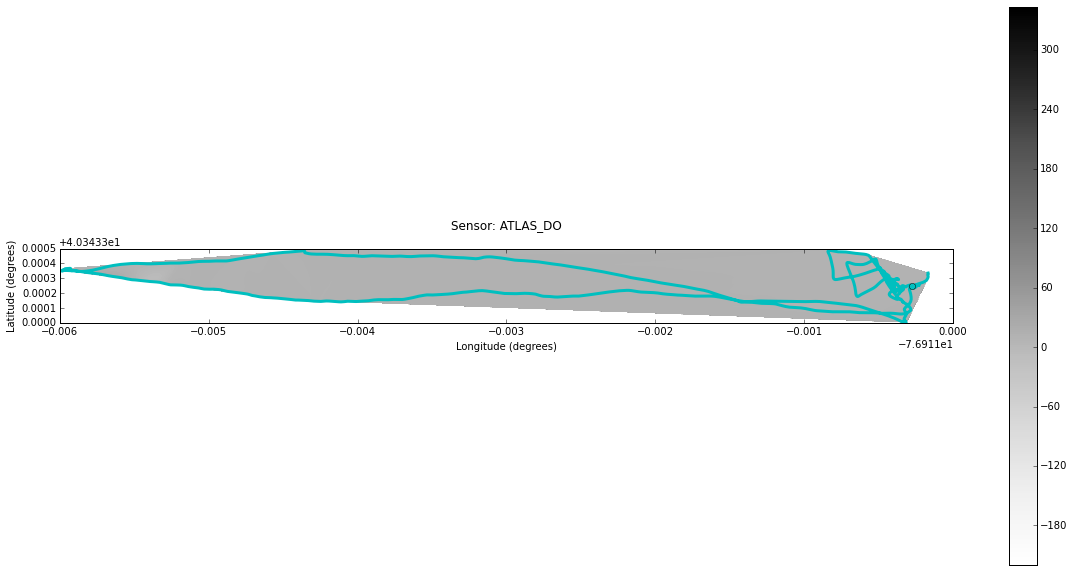

In [12]:
## Create a 2D surface plot

# Create matrices of the positions and data values.
points = sensor[['latitude', 'longitude']].as_matrix()
values = sensor[sensor_data]

# Create a grid over the range of the data.
grid_x, grid_y = np.mgrid[sensor.latitude.max():sensor.latitude.min():1000j,
                          sensor.longitude.min():sensor.longitude.max():1000j]
grid_z = scipy.interpolate.griddata(points, values, (grid_x, grid_y), method='cubic')

# Plot the sensor data as an image.
fig = plt.figure(figsize=(20,10))
plt.imshow(grid_z, aspect='equal', cmap='Greys',
           extent=[sensor.longitude.min(), sensor.longitude.max(),
                   sensor.latitude.min(), sensor.latitude.max()])

plt.colorbar()
plt.title("Sensor: " + sensor_name + "\n")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.hold(True)

# Plot the trajectory of the vehicle as an overlay.
plt.plot(points[:,1], points[:,0], 'c-', linewidth=3)
plt.plot(points[0,1], points[0,0], 'co')
plt.show()

# Save the figure to disk.
fig.savefig(sensor_name + '.png', dpi=fig.dpi)

In [ ]:
## Create a 3D trail plot
x = sensor['longitude'].as_matrix()
y = sensor['latitude'].as_matrix()
z = sensor[sensor_data].as_matrix()

import matplotlib.cm as cm
import matplotlib.colors as colors

# Create normalized color entries for each sensor reading.
norm = colors.Normalize(min(z), max(z))
colors = cm.jet(norm(z))
m = cm.ScalarMappable(cmap=cm.jet, norm=norm)
m.set_array(colors)

# Create a 3D plot that creates a vertical trail.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x, y, [min(z)] * len(z), 5e-5, 5e-5, z - min(z), color=colors, alpha=0.8, edgecolor='none')

plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Sensor: ' + sensor_name, fontsize=20)

fig.colorbar(m, shrink=0.5, aspect=5)
fig.show()

# Save the figure to disk.
fig.savefig(sensor_name + '_3d.png', dpi=fig.dpi)